We would like to acknowledge [AnalyticsVidhya blog](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/) for providing valuable insights and resources that contributed to the development of our project and code. The information and code snippets obtained from the blog were instrumental in guiding our implementation and enhancing our understanding of the subject matter. We are grateful for the contributions made by the authors of this blog.

## Import Packages

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import pandas as pd
import nltk
nltk.download('stopwords')
import numpy as np
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
stop_words = set(stopwords.words('english'))
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras import backend as K
import gensim
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Attention
from keras.layers import TimeDistributed
from tensorflow.keras.layers import Layer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Dataset Loading

In [ ]:
dataset = load_dataset("cnn_dailymail", "3.0.0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [ ]:
train_dataset = dataset['train'] # [:100000]

In [ ]:
train_df = pd.DataFrame(train_dataset)


In [ ]:
train_df.head()

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


## Preprocessing

### Preprocessing the text

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would","there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
def text_cleaner(text,num):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1: #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [ ]:
#call the function
def cleaning_text(df):
  cleaned_text = []
  for t in df['article']:
      cleaned_text.append(text_cleaner(t,0))

  return cleaned_text


In [ ]:
#call the function
def cleaning_summary(df):
  cleaned_summary = []
  for t in df['highlights']:
      cleaned_summary.append(text_cleaner(t,1))
  return cleaned_summary


In [ ]:
train_df['cleaned_article'] = cleaning_text(train_df)
train_df['cleaned_highlights'] = cleaning_summary(train_df)

In [ ]:
train_df

,article,highlights,id,cleaned_article,cleaned_highlights
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,london england harry potter star daniel radcli...,harry potter star daniel radcliffe gets fortun...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9,editor note behind scenes series cnn correspon...,mentally ill inmates in miami are housed on th...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37,minneapolis minnesota drivers minneapolis brid...,new thought was going to die driver says man s...
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88,washington doctors removed five small polyps p...,five small polyps found during procedure none ...
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a,national football league indefinitely suspende...,new nfl chief atlanta falcons owner critical o...
...,...,...,...,...,...
287108,"The nine-year-old daughter of a black, unarmed...","Rumain Brisbon, 34, was killed after Phoenix p...",279a12d3ee37b8109cc192a9e88115a5a631fb06,nine year old daughter black unarmed man shot ...,rumain brisbon was killed after phoenix police...
287109,Legalising assisted suicide is a slippery slop...,"Theo Boer, a European assisted suicide watchdo...",b5bc9d404a9a5d890c9fc26550b67e6d8d83241f,legalising assisted suicide slippery slope tow...,theo boer european assisted suicide watchdog s...
287110,A group calling itself 'The Women of the 99 Pe...,Ohio congressman criticised for 'condoning the...,500862586f925e406f8b662934e1a71bbee32463,group calling women percent making robocalls a...,ohio congressman criticised for condoning the ...
287111,Most men enjoy a good pint of lager or real al...,The Black Country Ale Tairsters have been to 1...,32a1f9e5c37a938c0c0bca1a1559247b9c4334b2,men enjoy good pint lager real ale watching fo...,the black country ale tairsters have been to p...


### Visualise the dataset

(array([ 11.,  69., 288., 536., 746., 894., 851., 804., 726., 697., 740.,
        620., 569., 529., 462., 369., 284., 208., 169., 121.,  96.,  48.,
         54.,  35.,  19.,  16.,  18.,  12.,   7.,   2.]),
 array([  10. ,   44.2,   78.4,  112.6,  146.8,  181. ,  215.2,  249.4,
         283.6,  317.8,  352. ,  386.2,  420.4,  454.6,  488.8,  523. ,
         557.2,  591.4,  625.6,  659.8,  694. ,  728.2,  762.4,  796.6,
         830.8,  865. ,  899.2,  933.4,  967.6, 1001.8, 1036. ]),
 <BarContainer object of 30 artists>)

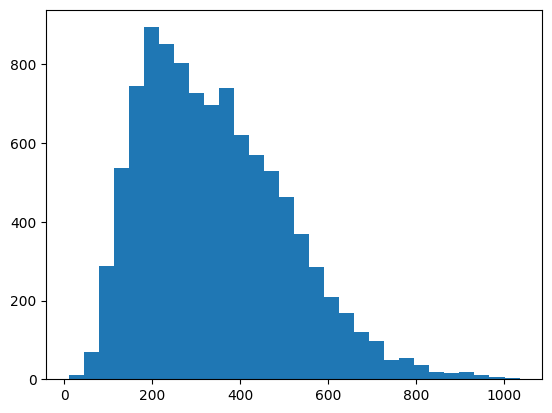

In [ ]:

text_word_count = []
summary_word_count = []

for i in train_df['cleaned_article']:
    text_word_count.append(len(i.split()))

for i in train_df['cleaned_highlights']:
    summary_word_count.append(len(i.split()))

plt.hist(text_word_count, bins=30)

(array([9.9400e+02, 4.6580e+03, 2.0568e+04, 3.4815e+04, 3.0309e+04,
        7.8000e+03, 5.1500e+02, 1.6000e+02, 8.5000e+01, 4.2000e+01,
        2.5000e+01, 9.0000e+00, 7.0000e+00, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  3. ,  13.2,  23.4,  33.6,  43.8,  54. ,  64.2,  74.4,  84.6,
         94.8, 105. , 115.2, 125.4, 135.6, 145.8, 156. , 166.2, 176.4,
        186.6, 196.8, 207. , 217.2, 227.4, 237.6, 247.8, 258. , 268.2,
        278.4, 288.6, 298.8, 309. ]),
 <BarContainer object of 30 artists>)

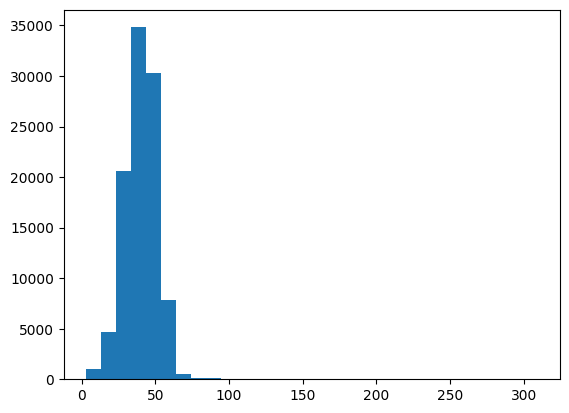

In [ ]:
plt.hist(summary_word_count, bins=30)

### Establishing a max_len for text and summary

In [ ]:
max_summary_len = 30
max_text_len = 250

In [ ]:
cleaned_text = np.array(train_df['cleaned_article'])
cleaned_summary = np.array(train_df['cleaned_highlights'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

training_df=pd.DataFrame({'text':short_text,'summary':short_summary}, )


In [ ]:
training_df.shape

(2126, 2)

### Creating train, val and test datasets

In [ ]:
training_df['summary'] = training_df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
training_df.head()

,text,summary
0,los angeles california alex trebek long time h...,sostok alex trebek suffered heart attack at ho...
1,year ago thursday report born cnn com launched...,sostok report initiative launched august on cn...
2,flash floods landslides triggered weekend trop...,sostok flash floods and landslides kill at lea...
3,harare zimbabwe zimbabwe urgently needs form n...,sostok new pm zimbabwe urgently needs governme...
4,daughter sen dick durbin died saturday congeni...,sostok illinois democratic sen dick durbin dau...


In [ ]:
x_tr,x_val,y_tr,y_val=train_test_split(np.array(training_df['text']),np.array(training_df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
print(f'training samples: {len(x_tr)}')
print(f'validation samples: {len(x_val)}')

training samples: 1913
validation samples: 213


In [ ]:
print((x_tr).shape)

(1913,)


### Tokenising text

In [ ]:
#prepare a tokenizer
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 63.158644260894334
Total Coverage of rare words: 10.033683332784744


In [ ]:
with tf.device('/device:GPU:0'):
  x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
  x_tokenizer.fit_on_texts(list(x_tr))
  x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
  x_val_seq = x_tokenizer.texts_to_sequences(x_val)

  x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
  x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')


In [ ]:
x_voc   =  len(x_tokenizer.word_index) + 1
print(x_voc)

28089


In [ ]:
print(x_tr.shape)
print(x_val.shape)

(1913, 200)
(213, 200)


### Tokenizing summary

In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 89.94746059544659
Total Coverage of rare words: 35.002134623594706


In [ ]:
with tf.device('/device:GPU:0'):
  y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
  y_tokenizer.fit_on_texts(list(y_tr))

  #convert text sequences into integer sequences
  y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
  y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

  #padding zero upto maximum length
  y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
  y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')


In [ ]:
print(y_tr.shape)
print(y_val.shape)
y_voc   =  len(y_tokenizer.word_index) +1
print(y_voc)

## Training and Validation

## Model

In [ ]:
with tf.device('/device:GPU:0'):
  K.clear_session()

  latent_dim = 25
  embedding_dim=10

  # Encoder
  encoder_inputs = Input(shape=(max_text_len,))

  #embedding layer
  enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

  #encoder lstm 1
  encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

  #encoder lstm 2
  encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
  encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

  #encoder lstm 3
  encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
  encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

  decoder_inputs = Input(shape=(None,))

  dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
  decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

  decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
  decoder_outputs = decoder_dense(decoder_outputs)


In [ ]:
with tf.device('/device:GPU:0'):
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 200, 10)              280890    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 200, 25),            3600      ['embedding[0][0]']           
                              (None, 25),                                                         
                              (None, 25)]                                                         
                                                                                              

In [ ]:
print(type(model))

In [ ]:
with tf.device('/device:GPU:0'):
  model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
for layer in model.layers:
    if hasattr(layer, 'weights'):
        for weight in layer.weights:
            print(f"{layer.name} weight device:", weight.device)


In [ ]:
temp_x_val = x_val
temp_y_val = y_val

In [ ]:
import torch
with tf.device('/device:GPU:0'):

  x_tr = tf.convert_to_tensor(x_tr)
  y_tr = tf.convert_to_tensor(y_tr)

  x_val = tf.convert_to_tensor(x_val)
  y_val = tf.convert_to_tensor(y_val)

  # Check the device placement of the tensor
  print("Tensor device:", x_tr.device)


Tensor device: /job:localhost/replica:0/task:0/device:GPU:0


In [ ]:
with tf.device('/device:GPU:0'): #1800 sec
  history=model.fit([x_tr,y_tr[:,:-1]], tf.reshape(y_tr, [y_tr.shape[0], y_tr.shape[1], 1])[:, 1:] ,epochs=50,batch_size=1, validation_data=([x_val,y_val[:,:-1]], tf.reshape(y_val, [y_val.shape[0], y_val.shape[1], 1])[:, 1:]))

Epoch 1/50
1913/1913 [==============================] - 80s 36ms/step - loss: 3.6840 - val_loss: 2.9846
Epoch 2/50
1913/1913 [==============================] - 46s 24ms/step - loss: 3.1336 - val_loss: 2.9604
Epoch 3/50
1913/1913 [==============================] - 45s 23ms/step - loss: 3.0982 - val_loss: 2.9355
Epoch 4/50
1913/1913 [==============================] - 46s 24ms/step - loss: 3.0717 - val_loss: 2.9186
Epoch 5/50
1913/1913 [==============================] - 45s 24ms/step - loss: 3.0479 - val_loss: 2.9143
Epoch 6/50
1913/1913 [==============================] - 45s 24ms/step - loss: 3.0257 - val_loss: 2.9122
Epoch 7/50
1913/1913 [==============================] - 45s 24ms/step - loss: 3.0038 - val_loss: 2.9052
Epoch 8/50
1913/1913 [==============================] - 45s 24ms/step - loss: 2.9803 - val_loss: 2.8955
Epoch 9/50
1913/1913 [==============================] - 46s 24ms/step - loss: 2.9545 - val_loss: 2.8890
Epoch 10/50
1913/1913 [==============================] - 46s 24m

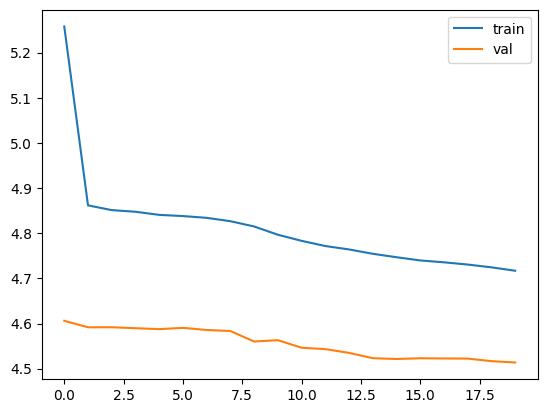

In [ ]:
# from matplotlib import pyplot
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='val')
# pyplot.legend()
# pyplot.show()
# # lstm with 20 epochs

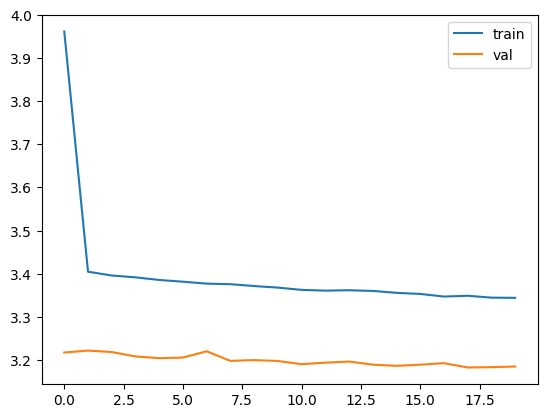

In [ ]:
# from matplotlib import pyplot
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='val')
# pyplot.legend()
# pyplot.show()

# with change in maxtextlen and maxsummarylen

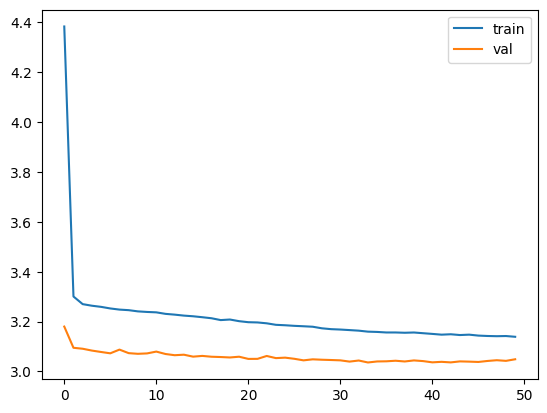

In [ ]:
# from matplotlib import pyplot
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='val')
# pyplot.legend()
# pyplot.show()

# # 5o epochs, 2 batch size 24 mins

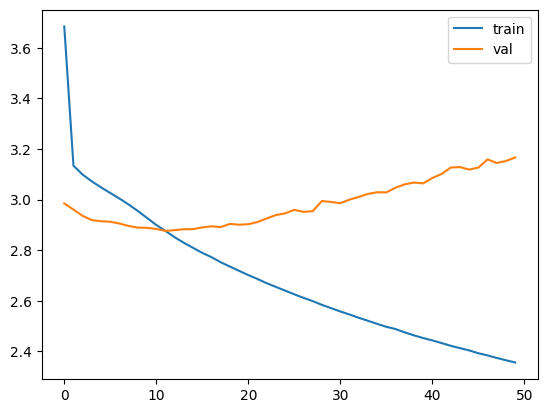

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

## Inference

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:

encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))

    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(1, len(reverse_target_word_index) + 1):
  if reverse_target_word_index[i] == 'eostok':
    print(i)

In [ ]:
summaries = []
predictions = []
for i in range(0,10):
    #print("Review:",seq2text(x_tr[i]))
    summaries.append(seq2summary(y_tr[i]))
    predictions.append(decode_sequence(x_tr[i].reshape(1,max_text_len)))

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=d5b523b562ebc3fcf703d78dbbef8b22a073baf67827bf4cef0612577f81a904
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)


In [2]:
from evaluate import load

rouge = load('rouge')

predictions = predictions
references = summaries

results = rouge.compute(predictions=predictions, references=references)

print(results)

{'rouge1': 0.1049049049046046, 'rouge2': 0.01270707070707071, 'rougeL': 0.043043043043043, 'rougeLsum': 0.00020202020202021}
